In [1]:
# Setup matplotlib
import numpy as np
#import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, separation_score, find_efficiency_errors, \
                         np_printoptions)

from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
my_cmap.set_under('w',1)

In [3]:
from rootpy.plotting import Hist, Hist2D, Graph, Efficiency
from rootpy.io import root_open
import rootpy.plotting.root2matplotlib as rplt

import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

Welcome to JupyROOT 6.12/07


In [4]:
infile_effie = '../test6/histos_tbc_add.29.root'
infile_effie200 = '../test6/histos_tbc_200_add.29.root'
infile_rates = '../test6/histos_tbb_add.29.root'
infile_rates140 = '../test6/histos_tbb_140_add.29.root'
infile_rates250 = '../test6/histos_tbb_250_add.29.root'
infile_rates300 = '../test6/histos_tbb_300_add.29.root'

hname2026_f = lambda hname: 'emtf2026_' + hname[5:]

color_a = 'red'
color_b = 'blue'

from six.moves import range, zip, map, filter

def draw_cms_lumi_puX(pu, axes=None):
  if axes is None:
    axes = plt.gca()
  axes.text(0.01, 1.02, r'CMS', fontsize=7.5, fontweight='bold', transform=axes.transAxes)
  axes.text(0.09, 1.02, r'Phase-2 Simulation', fontsize=7.5, transform=axes.transAxes)
  axes.text(0.99, 1.02, pu, fontsize=7.5, ha='right', transform=axes.transAxes)

def draw_cms_lumi_pu0(axes=None):
  draw_cms_lumi_puX(pu=r'<PU>=0', axes=axes)

def draw_cms_lumi_pu200(axes=None):
  draw_cms_lumi_puX(pu=r'<PU>=200', axes=axes)

def draw_cms_lumi_pu140to300(axes=None):
  draw_cms_lumi_puX(pu=r'<PU>=140,200,250,300', axes=axes)

### Resolution

In [5]:
def make_fits(h2):
  # Do gaussian fit to extract the resolution of each pT bin
  n = h2.GetNbinsX()
  gr1 = Graph(n)
  gr2 = Graph(n)
  for i in xrange(n):
    h_py = h2.ProjectionY('_py', i+1, i+1)
    if h_py.Integral() < 20:  # not enough stats
      continue

    if 50 <= i <= 60:  # high pT, not enough entries (300 bins -> 150)
      h_py.Rebin(2)
    elif i >= 86:      # low pT, resolution affected by finite bin width
      h_py = h2.ProjectionY('_py', i+1, i+2)  # merge i & (i+1) entries
      if i == 96:      # even lower pT, resolution affected by finite bin width
        h_py = h2.ProjectionY('_py', i+1, i+4)  # merge i & (i+4) entries
      elif i >= 96:
        continue

    r = h_py.Fit('gaus', 'SNQ', '', -1, 1.5)
    mean, sigma, meanErr, sigmaErr = r.Parameter(1), r.Parameter(2), r.ParError(1), r.ParError(2)
    x = 1.0/h2.GetXaxis().GetBinCenter(i+1)
    gr1.SetPoint(i, x, mean)
    gr1.SetPointError(i, 0, 0, meanErr, meanErr)
    gr2.SetPoint(i, x, sigma)
    gr2.SetPointError(i, 0, 0, sigmaErr, sigmaErr)
  return (gr1, gr2)

def doit():
  fig, ax = plt.subplots()
  rplt.hist2d(h, vmin=1, cmap=my_cmap, axes=ax)
  ax.set_xlabel(r'gen $q/p_{\mathrm{T}}$ [1/GeV]')
  ax.set_ylabel(r'$q/p_{\mathrm{T}}$ [1/GeV]')
  draw_cms_lumi_pu0(axes=ax)
  plt.show()

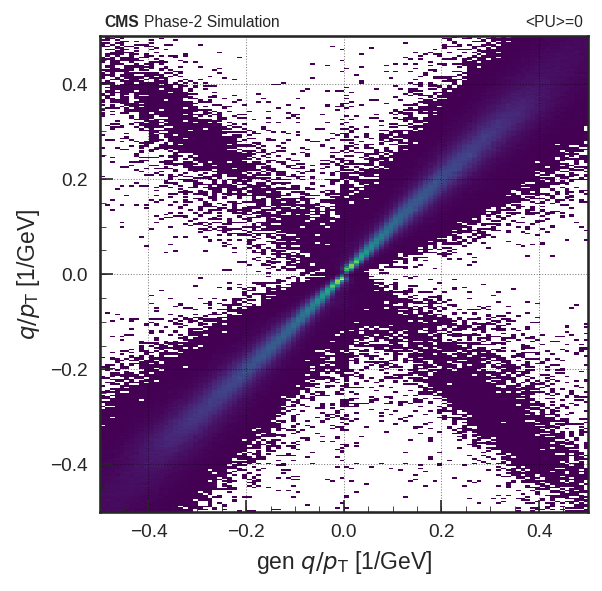

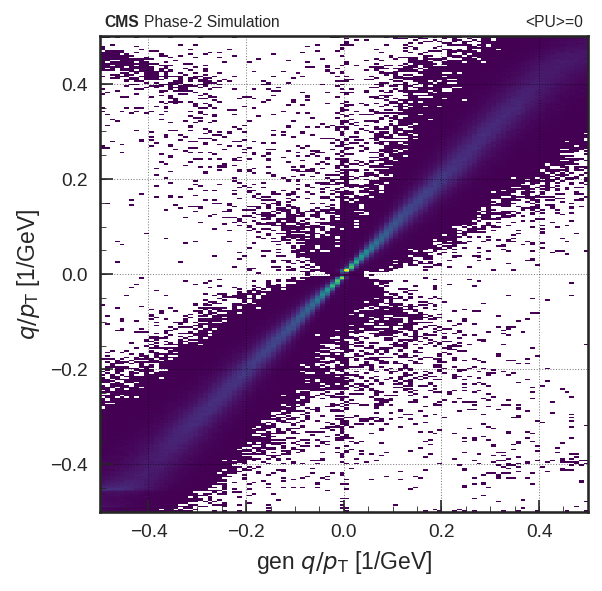

In [6]:
hname = 'emtf_l1pt_vs_genpt'

with root_open(infile_effie) as f:
  h2a = f.Get(hname)
  h2a.SetDirectory(0) # memory resident
  h2b = f.Get(hname2026_f(hname))
  h2b.SetDirectory(0) # memory resident

h = h2a
doit()

h = h2b
doit()

In [7]:
def doit1():
  fig, ax = plt.subplots()
  rplt.errorbar(gr1a, color=color_a, ecolor=color_a, markerfacecolor=color_a, marker='.', markersize=6.4, lw=0.8, axes=ax)
  rplt.errorbar(gr1b, color=color_b, ecolor=color_b, markerfacecolor=color_b, marker='.', markersize=6.4, lw=0.8, axes=ax)
  ax.set_xlabel(r'gen $p_{\mathrm{T}}$ [GeV]')
  ax.set_ylabel(r'$\Delta(p_{\mathrm{T}})/p_{\mathrm{T}}$ bias')
  ax.set_xlim(1,80)
  ax.set_ylim(-0.5,0.5)
  ax.set_xscale('log')
  ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))
  draw_cms_lumi_pu0(axes=ax)
  plt.show()

def doit2():
  fig, ax = plt.subplots()
  rplt.errorbar(gr2a, color=color_a, ecolor=color_a, markerfacecolor=color_a, marker='.', markersize=6.4, lw=0.8, axes=ax)
  rplt.errorbar(gr2b, color=color_b, ecolor=color_b, markerfacecolor=color_b, marker='.', markersize=6.4, lw=0.8, axes=ax)
  ax.set_xlabel(r'gen $p_{\mathrm{T}}$ [GeV]')
  ax.set_ylabel(r'$\Delta(p_{\mathrm{T}})/p_{\mathrm{T}}$ resolution')
  ax.set_xlim(1,80)
  ax.set_ylim(0,0.5)
  ax.set_xscale('log')
  ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))
  draw_cms_lumi_pu0(axes=ax)
  plt.show()

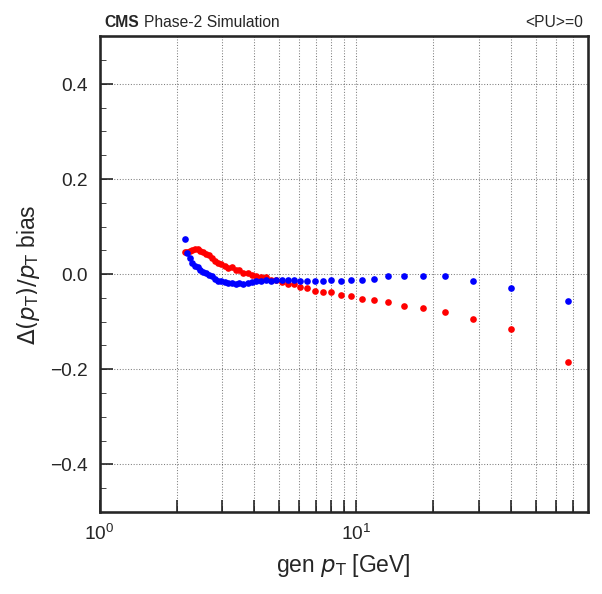

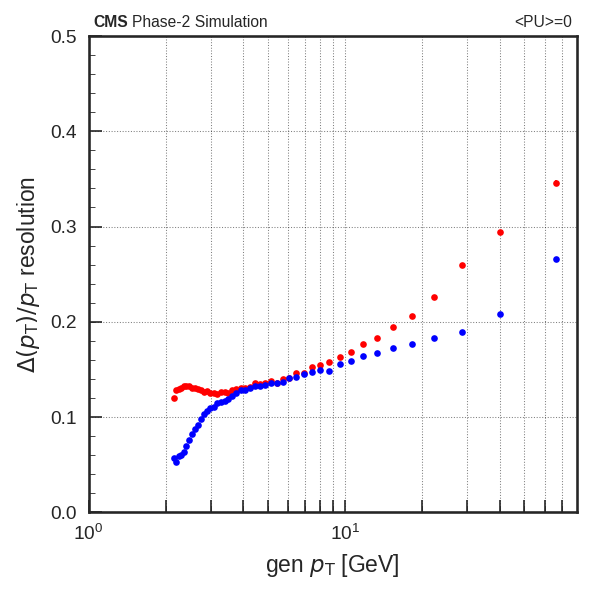

In [8]:
hname = 'emtf_l1ptres_vs_genpt'

with root_open(infile_effie) as f:
  h2a = f.Get(hname)
  gr1a, gr2a = make_fits(h2a)
  h2b = f.Get(hname2026_f(hname))
  gr1b, gr2b = make_fits(h2b)

doit1()

doit2()

### Efficiency

In [9]:
def doit():
  fig, ax = plt.subplots()
  rplt.errorbar(h1a_eff.graph, color=color_a, ecolor=color_a, markerfacecolor=color_a, marker=',', lw=1.2, axes=ax)
  rplt.errorbar(h1b_eff.graph, color=color_b, ecolor=color_b, markerfacecolor=color_b, marker=',', lw=1.2, axes=ax)
  ax.set_xlabel(r'gen $p_{\mathrm{T}}$ [GeV]')
  ax.set_ylabel(r'$\varepsilon$')
  ax.set_xlim(0,120)
  ax.set_ylim(0,1.1)
  ax.plot([0,120], [0.97,0.97], color='gray', linestyle='dotted', lw=1)
  if pu == 0:
    draw_cms_lumi_pu0(axes=ax)
  elif pu == 200:
    draw_cms_lumi_pu200(axes=ax)
  plt.show()

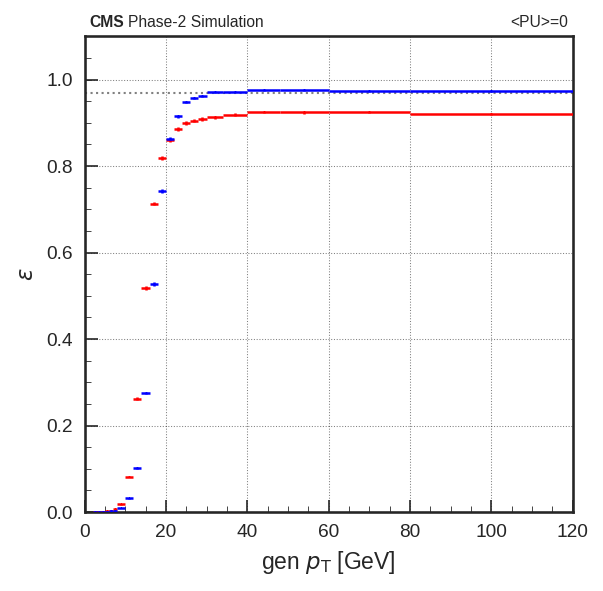

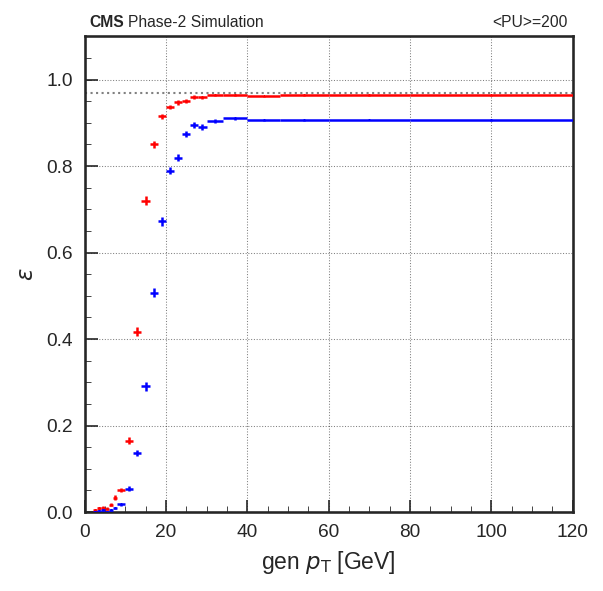

In [10]:
hname = 'emtf_eff_vs_genpt_l1pt20'

with root_open(infile_effie) as f:
  pu = 0
  h1a_denom = f.Get(hname + '_denom')
  h1a_numer = f.Get(hname + '_numer')
  h1b_denom = f.Get(hname2026_f(hname) + '_denom')
  h1b_numer = f.Get(hname2026_f(hname) + '_numer')
  h1a_eff = Efficiency(h1a_numer, h1a_denom)
  h1b_eff = Efficiency(h1b_numer, h1b_denom)

doit()

with root_open(infile_effie200) as f:
  pu = 200
  h1a_denom = f.Get(hname + '_denom')
  h1a_numer = f.Get(hname + '_numer')
  h1b_denom = f.Get(hname2026_f(hname) + '_denom')
  h1b_numer = f.Get(hname2026_f(hname) + '_numer')
  h1a_eff = Efficiency(h1a_numer, h1a_denom)
  h1b_eff = Efficiency(h1b_numer, h1b_denom)

doit()

In [11]:
def doit():
  fig, ax = plt.subplots()
  rplt.errorbar(h1a_eff.graph, color=color_a, ecolor=color_a, markerfacecolor=color_a, marker=',', lw=1.2, axes=ax)
  rplt.errorbar(h1b_eff.graph, color=color_b, ecolor=color_b, markerfacecolor=color_b, marker=',', lw=1.2, axes=ax)
  ax.set_xlabel(r'gen $p_{\mathrm{T}}$ [GeV]')
  ax.set_ylabel(r'$\varepsilon$')
  ax.set_xlim(2,1000)
  ax.set_ylim(0,1.1)
  ax.plot([2,1000], [0.97,0.97], color='gray', linestyle='dotted', lw=1)
  ax.set_xscale('log')
  if pu == 0:
    draw_cms_lumi_pu0(axes=ax)
  elif pu == 200:
    draw_cms_lumi_pu200(axes=ax)
  plt.show()

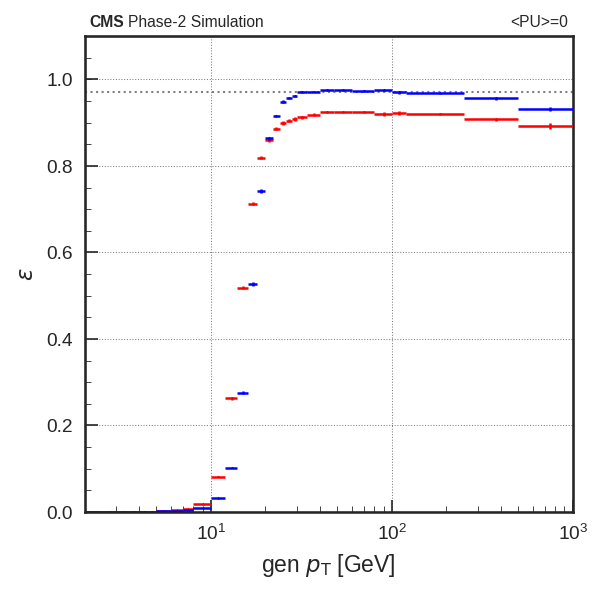

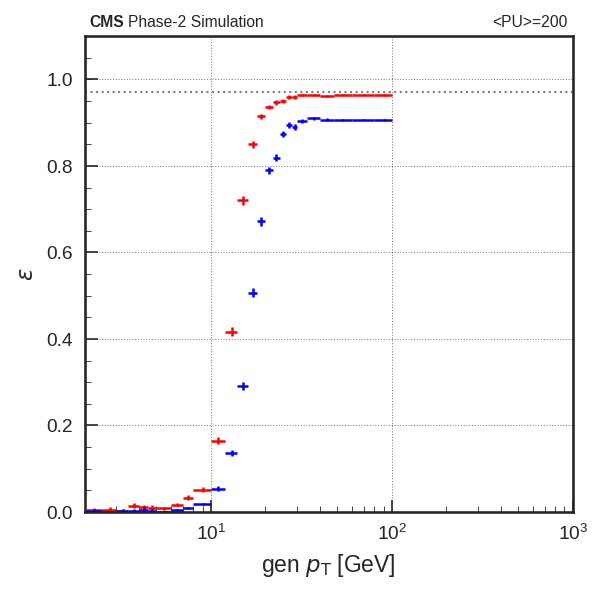

In [12]:
hname = 'emtf_eff_vs_genpt_highpt_l1pt20'

with root_open(infile_effie) as f:
  pu = 0
  h1a_denom = f.Get(hname + '_denom')
  h1a_numer = f.Get(hname + '_numer')
  h1b_denom = f.Get(hname2026_f(hname) + '_denom')
  h1b_numer = f.Get(hname2026_f(hname) + '_numer')
  h1a_eff = Efficiency(h1a_numer, h1a_denom)
  h1b_eff = Efficiency(h1b_numer, h1b_denom)

doit()

with root_open(infile_effie200) as f:
  pu = 200
  h1a_denom = f.Get(hname + '_denom')
  h1a_numer = f.Get(hname + '_numer')
  h1b_denom = f.Get(hname2026_f(hname) + '_denom')
  h1b_numer = f.Get(hname2026_f(hname) + '_numer')
  h1a_eff = Efficiency(h1a_numer, h1a_denom)
  h1b_eff = Efficiency(h1b_numer, h1b_denom)

doit()

In [13]:
def doit():
  fig, ax = plt.subplots()
  rplt.errorbar(h1a_eff.graph, color=color_a, ecolor=color_a, markerfacecolor=color_a, marker=',', lw=1.2, axes=ax)
  rplt.errorbar(h1b_eff.graph, color=color_b, ecolor=color_b, markerfacecolor=color_b, marker=',', lw=1.2, axes=ax)
  ax.set_xlabel(r'gen $\eta$ {gen $p_{\mathrm{T}}$ > 20 GeV}')
  ax.set_ylabel(r'$\varepsilon$')
  ax.set_xlim(1.0,2.5)
  ax.set_ylim(0,1.1)
  ax.plot([1.0,2.5], [0.97,0.97], color='gray', linestyle='dotted', lw=1)
  if pu == 0:
    draw_cms_lumi_pu0(axes=ax)
  elif pu == 200:
    draw_cms_lumi_pu200(axes=ax)
  plt.show()

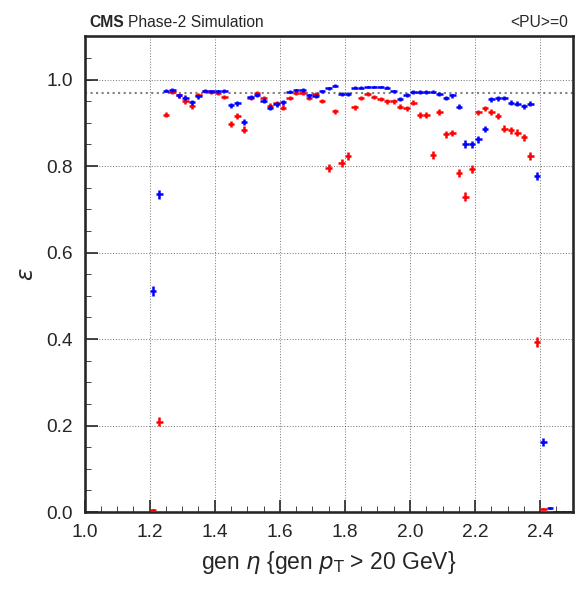

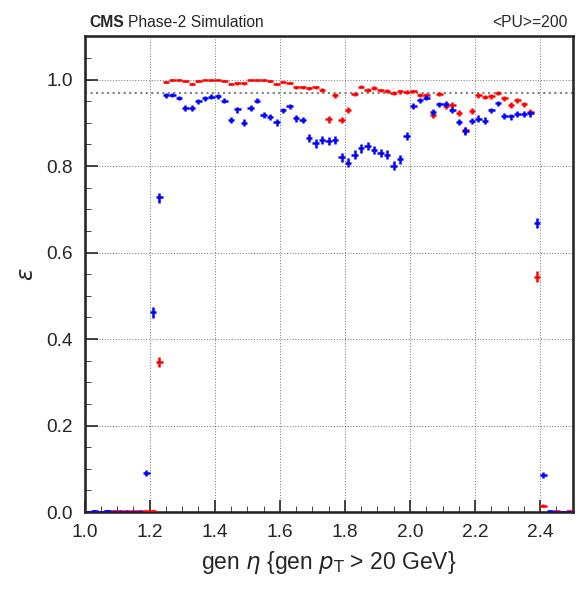

In [14]:
hname = 'emtf_eff_vs_geneta_l1pt20'

with root_open(infile_effie) as f:
  pu = 0
  h1a_denom = f.Get(hname + '_denom')
  h1a_numer = f.Get(hname + '_numer')
  h1b_denom = f.Get(hname2026_f(hname) + '_denom')
  h1b_numer = f.Get(hname2026_f(hname) + '_numer')
  h1a_eff = Efficiency(h1a_numer, h1a_denom)
  h1b_eff = Efficiency(h1b_numer, h1b_denom)

doit()

with root_open(infile_effie200) as f:
  pu = 200
  h1a_denom = f.Get(hname + '_denom')
  h1a_numer = f.Get(hname + '_numer')
  h1b_denom = f.Get(hname2026_f(hname) + '_denom')
  h1b_numer = f.Get(hname2026_f(hname) + '_numer')
  h1a_eff = Efficiency(h1a_numer, h1a_denom)
  h1b_eff = Efficiency(h1b_numer, h1b_denom)

doit()

In [15]:
def doit():
  fig, ax = plt.subplots()
  rplt.errorbar(h1a_eff.graph, color=color_a, ecolor=color_a, markerfacecolor=color_a, marker=',', lw=1.2, axes=ax)
  rplt.errorbar(h1b_eff.graph, color=color_b, ecolor=color_b, markerfacecolor=color_b, marker=',', lw=1.2, axes=ax)
  ax.set_xlabel(r'gen $\eta$ {gen $p_{\mathrm{T}}$ > 0 GeV}')
  ax.set_ylabel(r'$\varepsilon$')
  ax.set_xlim(1.0,2.5)
  ax.set_ylim(0,1.1)
  ax.plot([1.0,2.5], [0.97,0.97], color='gray', linestyle='dotted', lw=1)
  if pu == 0:
    draw_cms_lumi_pu0(axes=ax)
  elif pu == 200:
    draw_cms_lumi_pu200(axes=ax)
  plt.show()

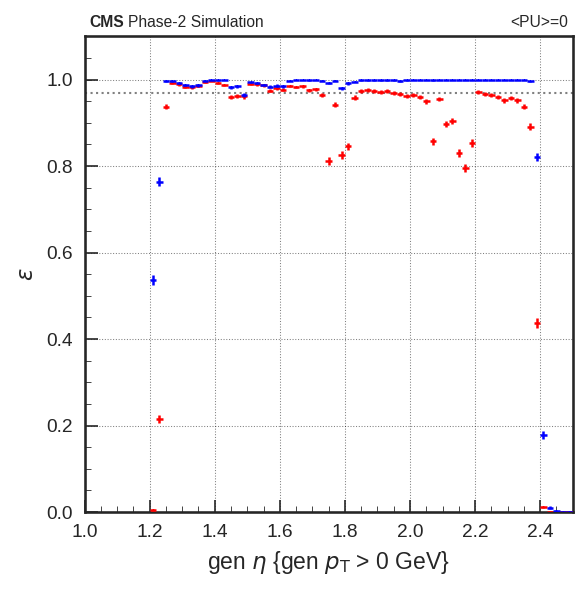

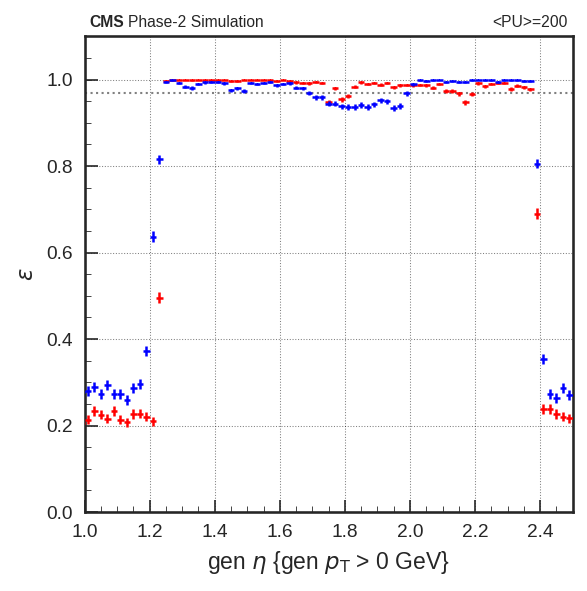

In [16]:
hname = 'emtf_eff_vs_geneta_l1pt0'

with root_open(infile_effie) as f:
  pu = 0
  h1a_denom = f.Get(hname + '_denom')
  h1a_numer = f.Get(hname + '_numer')
  h1b_denom = f.Get(hname2026_f(hname) + '_denom')
  h1b_numer = f.Get(hname2026_f(hname) + '_numer')
  h1a_eff = Efficiency(h1a_numer, h1a_denom)
  h1b_eff = Efficiency(h1b_numer, h1b_denom)

doit()

with root_open(infile_effie200) as f:
  pu = 200
  h1a_denom = f.Get(hname + '_denom')
  h1a_numer = f.Get(hname + '_numer')
  h1b_denom = f.Get(hname2026_f(hname) + '_denom')
  h1b_numer = f.Get(hname2026_f(hname) + '_numer')
  h1a_eff = Efficiency(h1a_numer, h1a_denom)
  h1b_eff = Efficiency(h1b_numer, h1b_denom)

doit()

In [17]:
def doit():
  fig, ax = plt.subplots()
  rplt.errorbar(h1a_eff.graph, color=color_a, ecolor=color_a, markerfacecolor=color_a, marker=',', lw=1.2, axes=ax)
  rplt.errorbar(h1b_eff.graph, color=color_b, ecolor=color_b, markerfacecolor=color_b, marker=',', lw=1.2, axes=ax)
  ax.set_xlabel(r'gen $\phi$ {gen $p_{\mathrm{T}}$ > 20 GeV}')
  ax.set_ylabel(r'$\varepsilon$')
  ax.set_xlim(-190,190)
  ax.set_ylim(0,1.1)
  ax.plot([-190,190], [0.97,0.97], color='gray', linestyle='dotted', lw=1)
  if pu == 0:
    draw_cms_lumi_pu0(axes=ax)
  elif pu == 200:
    draw_cms_lumi_pu200(axes=ax)
  plt.show()

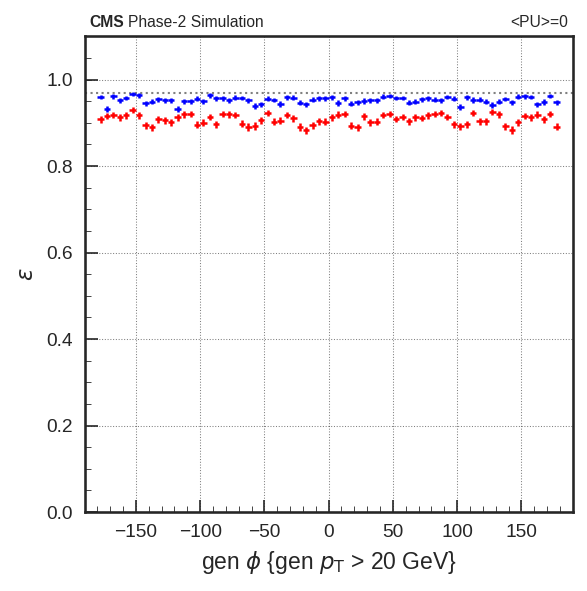

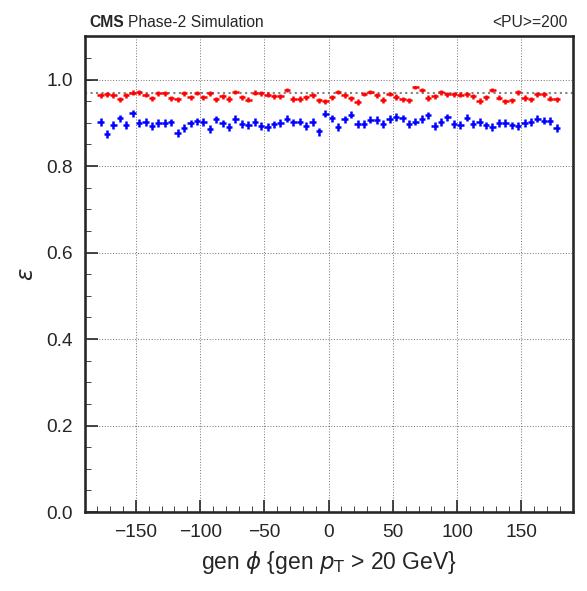

In [18]:
hname = 'emtf_eff_vs_genphi_l1pt20'

with root_open(infile_effie) as f:
  pu = 0
  h1a_denom = f.Get(hname + '_denom')
  h1a_numer = f.Get(hname + '_numer')
  h1b_denom = f.Get(hname2026_f(hname) + '_denom')
  h1b_numer = f.Get(hname2026_f(hname) + '_numer')
  h1a_eff = Efficiency(h1a_numer, h1a_denom)
  h1b_eff = Efficiency(h1b_numer, h1b_denom)

doit()

with root_open(infile_effie200) as f:
  pu = 200
  h1a_denom = f.Get(hname + '_denom')
  h1a_numer = f.Get(hname + '_numer')
  h1b_denom = f.Get(hname2026_f(hname) + '_denom')
  h1b_numer = f.Get(hname2026_f(hname) + '_numer')
  h1a_eff = Efficiency(h1a_numer, h1a_denom)
  h1b_eff = Efficiency(h1b_numer, h1b_denom)

doit()

In [19]:
def doit():
  fig, ax = plt.subplots()
  rplt.errorbar(h1a_eff.graph, color=color_a, ecolor=color_a, markerfacecolor=color_a, marker=',', lw=1.2, axes=ax)
  rplt.errorbar(h1b_eff.graph, color=color_b, ecolor=color_b, markerfacecolor=color_b, marker=',', lw=1.2, axes=ax)
  ax.set_xlabel(r'gen $d_{0}$ {gen $p_{\mathrm{T}}$ > 20 GeV}')
  ax.set_ylabel(r'$\varepsilon$')
  ax.set_xlim(0,120)
  ax.set_ylim(0,1.1)
  ax.plot([0,120], [0.97,0.97], color='gray', linestyle='dotted', lw=1)
  if pu == 0:
    draw_cms_lumi_pu0(axes=ax)
  elif pu == 200:
    draw_cms_lumi_pu200(axes=ax)
  plt.show()

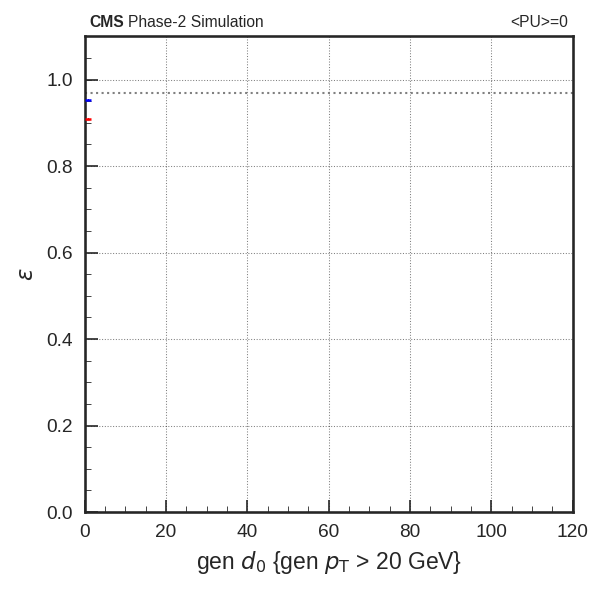

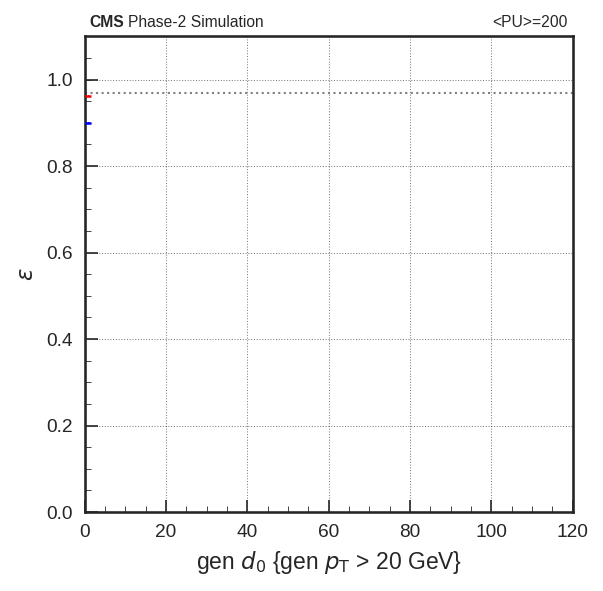

In [20]:
hname = 'emtf_eff_vs_gend0_l1pt20'

with root_open(infile_effie) as f:
  pu = 0
  h1a_denom = f.Get(hname + '_denom')
  h1a_numer = f.Get(hname + '_numer')
  h1b_denom = f.Get(hname2026_f(hname) + '_denom')
  h1b_numer = f.Get(hname2026_f(hname) + '_numer')
  h1a_eff = Efficiency(h1a_numer, h1a_denom)
  h1b_eff = Efficiency(h1b_numer, h1b_denom)

doit()

with root_open(infile_effie200) as f:
  pu = 200
  h1a_denom = f.Get(hname + '_denom')
  h1a_numer = f.Get(hname + '_numer')
  h1b_denom = f.Get(hname2026_f(hname) + '_denom')
  h1b_numer = f.Get(hname2026_f(hname) + '_numer')
  h1a_eff = Efficiency(h1a_numer, h1a_denom)
  h1b_eff = Efficiency(h1b_numer, h1b_denom)

doit()

In [21]:
def doit():
  fig, ax = plt.subplots()
  color_list = ("#333333", "#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")
  pt_list = (0, 10, 20, 30, 40, 50)
  for i, eff in enumerate(effs):
    color = color_list[i]
    pt = pt_list[i]
    label = r'L1 $p_{\mathrm{T}}$ > %i GeV' % pt
    rplt.errorbar(eff.graph, color=color, ecolor=color, markerfacecolor=color, marker=',', lw=1.2, axes=ax, label=label)
  ax.set_xlabel(r'gen $p_{\mathrm{T}}$ [GeV]')
  ax.set_ylabel(r'$\varepsilon$')
  ax.set_xlim(0,120)
  ax.set_ylim(0,1.1)
  ax.plot([0,120], [0.90,0.90], color='gray', linestyle='dotted', lw=1)
  ax.legend(fontsize=9)
  draw_cms_lumi_pu0(axes=ax)
  plt.show()

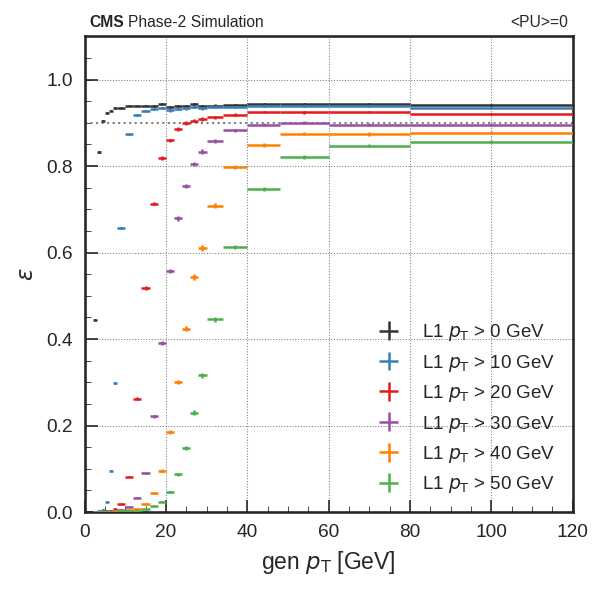

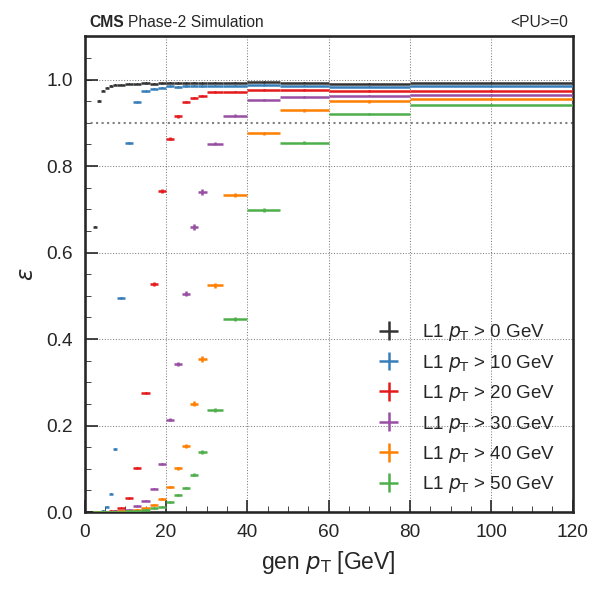

In [22]:
hname = 'emtf_eff_vs_genpt_l1pt%i'

with root_open(infile_effie) as f:
  effs = []
  for l in (0, 10, 20, 30, 40, 50):
    denom = f.Get((hname % l) + '_denom')
    numer = f.Get((hname % l) + '_numer')
    eff = Efficiency(numer, denom)
    effs.append(eff)

doit()

with root_open(infile_effie) as f:
  effs = []
  for l in (0, 10, 20, 30, 40, 50):
    denom = f.Get((hname2026_f(hname) % l) + '_denom')
    numer = f.Get((hname2026_f(hname) % l) + '_numer')
    eff = Efficiency(numer, denom)
    effs.append(eff)

doit()

### Rates

In [23]:
def make_ptcut(h):
  use_overflow = True
  binsum = 0
  binerr2 = 0
  for ib in xrange(h.GetNbinsX()+2-1, 0-1, -1):
    if (not use_overflow) and (ib == 0 or ib == h.GetNbinsX()+1):
      continue
    binsum += h.GetBinContent(ib)
    binerr2 += h.GetBinError(ib)**2
    h.SetBinContent(ib, binsum)
    h.SetBinError(ib, np.sqrt(binerr2))
  return

def make_rate(h, nevents):
  orbitFreq = 11246.
  nCollBunches = 2808  # assume lumi=8e34, PU=200, xsec_pp=80mb
  nZeroBiasEvents = float(nevents)
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  h.Scale(convFactorToHz / 1000.)
  return

In [24]:
def rplt_errorbar_filled(h, axes=None, **kwargs):
  if axes is None:
    axes = plt.gca()
  x = np.array(list(h.x()))
  y = np.array(list(h.y()))
  yerrl = np.array(list(h.yerrl()))
  yerrh = np.array(list(h.yerrh()))
  return axes.fill_between(x, y+yerrh, y-yerrl, **kwargs)

def draw_text(axes=None):
  if axes is None:
    axes = plt.gca()

  import re
  m = re.search(r'absEtaMin(\d*\.\d+|\d+)_absEtaMax(\d*\.\d+|\d+)', hname)
  try:
    #eta1 = m.group(1)
    #eta2 = m.group(2)
    eta1 = float(m.group(1))
    eta2 = float(m.group(2))
    text = r'${0} < |\eta| < {1}$'.format(eta1, eta2)
    axes.text(0.99, 0.95, text, fontsize=7.5, ha='right', transform=axes.transAxes)
  except:
    print('ERROR: regex failed.')

def doit():
  fig, axs = plt.subplots(2, 1, figsize=(4.2,4.2*6/5*8.4/8), gridspec_kw=dict(height_ratios=[5,1], hspace=0.08))
  ax = axs[0]
  ax.tick_params(labelbottom=False)
  rplt.hist(h1a, color=color_a, axes=ax)
  rplt_errorbar_filled(h1a, facecolor=color_a, alpha=0.2, axes=ax)
  rplt.hist(h1b, color=color_b, axes=ax)
  rplt_errorbar_filled(h1b, facecolor=color_b, alpha=0.2, axes=ax)
  ax.set_xlabel(r'$p_{\mathrm{T}}$ threshold [GeV]')
  ax.set_ylabel(r'Trigger rate [kHz]')
  ax.set_ylim(0.3,3e4)
  ax.set_yscale('log')
  draw_cms_lumi_pu200(axes=ax)
  draw_text(axes=ax)

  # Ratio plot
  ax = axs[1]
  ratio = h1a.Clone('ratio')
  ratio.Divide(h1b, h1a, 1, 1, '')
  rplt.hist(ratio, color=color_b, axes=ax)
  rplt_errorbar_filled(ratio, facecolor=color_b, alpha=0.2, axes=ax)
  ax.set_xlabel(r'$p_{\mathrm{T}}$ threshold [GeV]')
  ax.set_ylabel(r'Ratio')
  ax.set_ylim(0,2)
  plt.show()

old rates @18/20/22/25 GeV: 56.3382835388, 43.2619361877, 35.9294013977, 26.0304851532
new rates @18/20/22/25 GeV: 33.3630180359, 25.1750240326, 20.1644611359, 15.3983154297


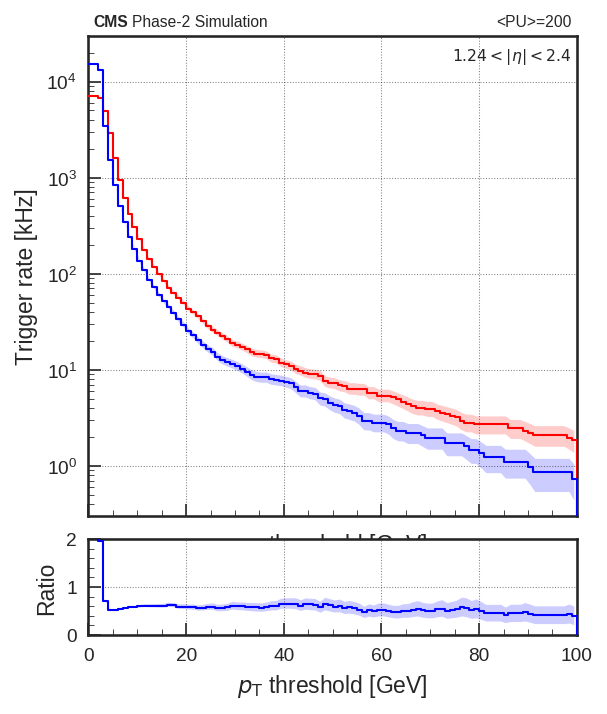

In [25]:
hname = 'emtf_absEtaMin1.24_absEtaMax2.4_qmin12_pt'

with root_open(infile_rates) as f:
  h_nevents = f.Get('nevents')
  assert(h_nevents != None)
  nevents = h_nevents.GetBinContent(2)

  h1a = f.Get('highest_' + hname)
  h1a.SetDirectory(0) # memory resident
  make_ptcut(h1a)
  make_rate(h1a, nevents)
  old_rates = [h1a.GetBinContent(h1a.FindBin(x)) for x in [18,20,22,25]]
  print('old rates @18/20/22/25 GeV: {0}, {1}, {2}, {3}'.format(*old_rates))

  h1b = f.Get('highest_' + hname2026_f(hname))
  h1b.SetDirectory(0) # memory resident
  make_ptcut(h1b)
  make_rate(h1b, nevents)
  new_rates = [h1b.GetBinContent(h1b.FindBin(x)) for x in [18,20,22,25]]
  print('new rates @18/20/22/25 GeV: {0}, {1}, {2}, {3}'.format(*new_rates))

doit()

old rates @18/20/22/25 GeV: 13.1985559464, 9.4100818634, 7.82136678696, 4.52172756195
new rates @18/20/22/25 GeV: 9.28787326813, 6.4770693779, 4.76614522934, 3.5440568924


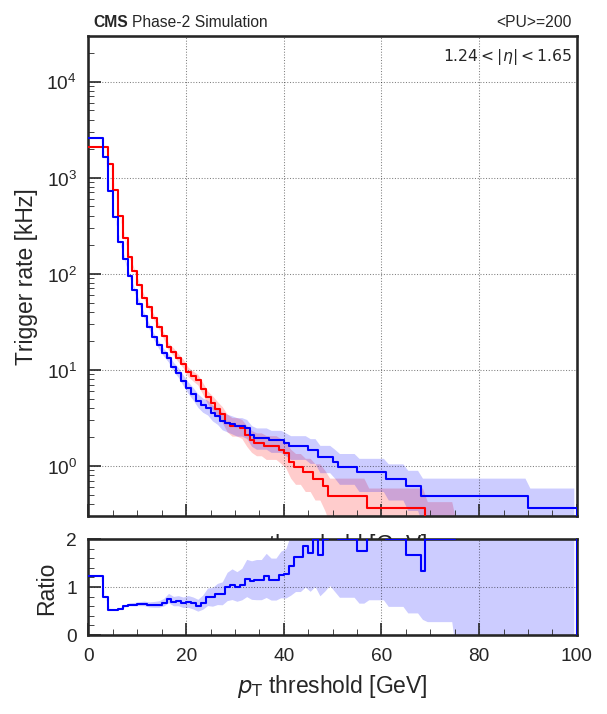

old rates @18/20/22/25 GeV: 30.7966308594, 25.0528144836, 21.0199222565, 15.6427335739
new rates @18/20/22/25 GeV: 16.0093593597, 12.3430938721, 10.1433353424, 7.82136678696


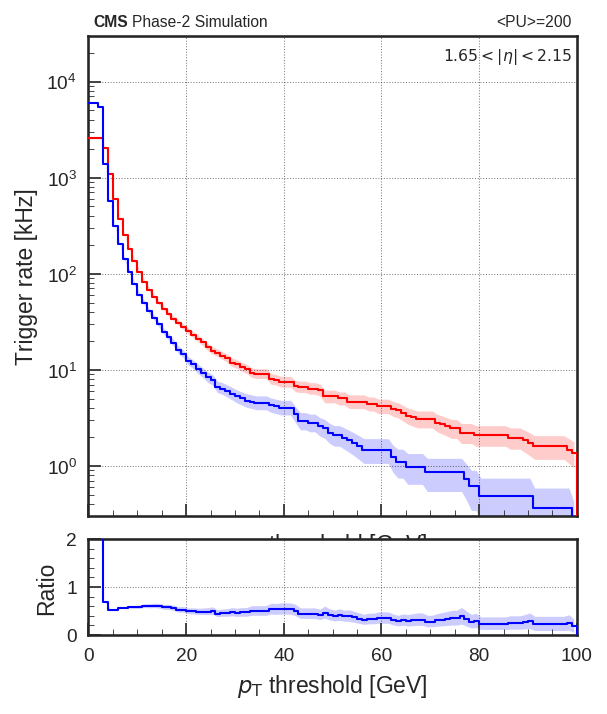

old rates @18/20/22/25 GeV: 12.3430938721, 8.79903793335, 7.08811378479, 5.86602497101
new rates @18/20/22/25 GeV: 8.18799304962, 6.4770693779, 5.37718963623, 4.15510082245


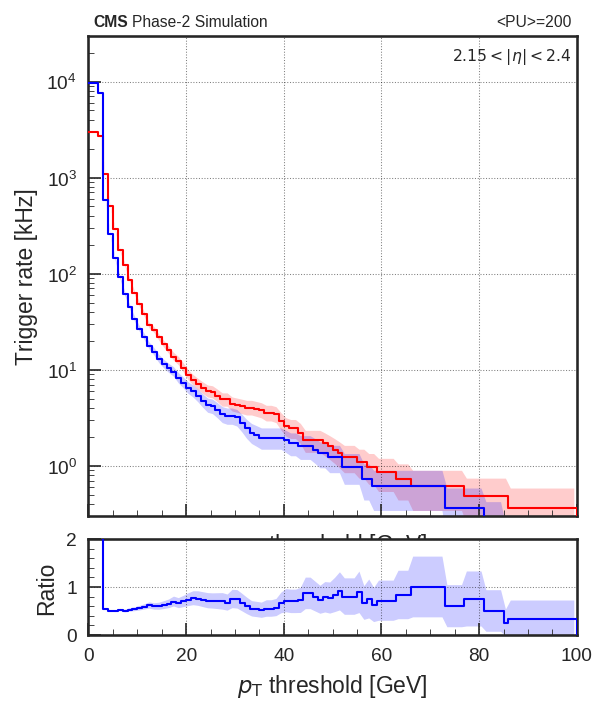

In [26]:
hnames = ['emtf_absEtaMin1.24_absEtaMax1.65_qmin12_pt',
          'emtf_absEtaMin1.65_absEtaMax2.15_qmin12_pt',
          'emtf_absEtaMin2.15_absEtaMax2.4_qmin12_pt',]

for hname in hnames:
  with root_open(infile_rates) as f:
    h_nevents = f.Get('nevents')
    assert(h_nevents != None)
    nevents = h_nevents.GetBinContent(2)

    h1a = f.Get('highest_' + hname)
    h1a.SetDirectory(0) # memory resident
    make_ptcut(h1a)
    make_rate(h1a, nevents)
    old_rates = [h1a.GetBinContent(h1a.FindBin(x)) for x in [18,20,22,25]]
    print('old rates @18/20/22/25 GeV: {0}, {1}, {2}, {3}'.format(*old_rates))

    h1b = f.Get('highest_' + hname2026_f(hname))
    h1b.SetDirectory(0) # memory resident
    make_ptcut(h1b)
    make_rate(h1b, nevents)
    new_rates = [h1b.GetBinContent(h1b.FindBin(x)) for x in [18,20,22,25]]
    print('new rates @18/20/22/25 GeV: {0}, {1}, {2}, {3}'.format(*new_rates))

  doit()

In [27]:
def doit():
  fig, ax = plt.subplots()
  rplt.errorbar(gr1a, color=color_a, ecolor=color_a, markerfacecolor=color_a, marker='.', markersize=8.4, lw=1.2, axes=ax)
  rplt.errorbar(gr1b, color=color_b, ecolor=color_b, markerfacecolor=color_b, marker='.', markersize=8.4, lw=1.2, axes=ax)
  for x, y in zip(gr1a.x(), gr1a.y()):
    ax.text(x + 2, y + 3, '%.1f' % y, fontsize=8)
  for x, y in zip(gr1b.x(), gr1b.y()):
    ax.text(x + 2, y + 3, '%.1f' % y, fontsize=8)

  # From Osvaldo's trigger xsec study
  #p0 = -0.004091 +- 0.001251
  #p1 = 0.02187 +- 6.462e-5
  #p2 = 9.102e-5 +- 5.429e-7
  get_rates_from_run2_xsec = lambda x: -0.004091 + 0.02187*x + 9.102e-5*x*x
  x = np.arange(0,350)
  y = get_rates_from_run2_xsec(x)
  y *= 2808
  y /= 1000
  ax.plot(x, y, color='#cccccc', linestyle='dashed', lw=1)

  ax.set_xlabel(r'# of pileup vertices')
  ax.set_ylabel(r'Trigger rate [kHz]')
  ax.set_xlim(0,350)
  ax.set_ylim(0,100)
  draw_cms_lumi_pu140to300(axes=ax)
  plt.show()

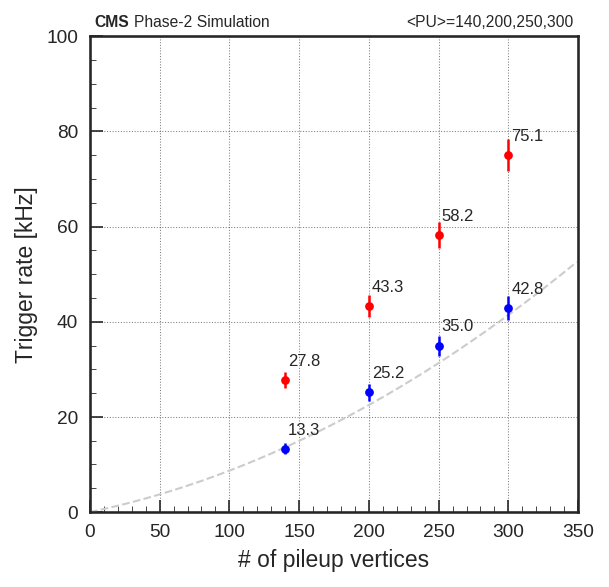

In [28]:
hname = 'emtf_absEtaMin1.24_absEtaMax2.4_qmin12_pt'

pileup_list = [140, 200, 250, 300]
infile_list = [infile_rates140, infile_rates, infile_rates250, infile_rates300]

gr1a = Graph(len(pileup_list))
gr1b = Graph(len(pileup_list))

for i, (pu, infile) in enumerate(zip(pileup_list, infile_list)):
  with root_open(infile) as f:
    h_nevents = f.Get('nevents')
    assert(h_nevents != None)
    nevents = h_nevents.GetBinContent(2)

    h1a = f.Get('highest_' + hname)
    h1a.SetDirectory(0) # memory resident
    make_ptcut(h1a)
    make_rate(h1a, nevents)
    rate, rate_err = h1a.GetBinContent(h1a.FindBin(20)), h1a.GetBinError(h1a.FindBin(20))
    gr1a.SetPoint(i, pu, rate)
    gr1a.SetPointError(i, 0, 0, rate_err, rate_err)

    h1b = f.Get('highest_' + hname2026_f(hname))
    h1b.SetDirectory(0) # memory resident
    make_ptcut(h1b)
    make_rate(h1b, nevents)
    rate, rate_err = h1b.GetBinContent(h1b.FindBin(20)), h1b.GetBinError(h1b.FindBin(20))
    gr1b.SetPoint(i, pu, rate)
    gr1b.SetPointError(i, 0, 0, rate_err, rate_err)

doit()

In [29]:
def doit():
  fig, ax = plt.subplots()
  rplt.hist(h1a, color=color_a, axes=ax)
  rplt.hist(h1b, color=color_b, axes=ax)
  rplt.hist(h1a, color=color_a, fill=True, alpha=0.2, axes=ax)
  rplt.hist(h1b, color=color_b, fill=True, alpha=0.2, axes=ax)
  rplt.errorbar(h1a, color=color_a, ecolor=color_a, markerfacecolor=color_a, marker=',', lw=1, axes=ax)
  rplt.errorbar(h1b, color=color_b, ecolor=color_b, markerfacecolor=color_b, marker=',', lw=1, axes=ax)
  ax.set_xlabel(r'$|\eta|$')
  ax.set_ylabel(r'Trigger rate per unit $\eta$ [kHz]')
  ax.set_xlim(1.0,2.5)
  draw_cms_lumi_pu200(ax)
  plt.show()

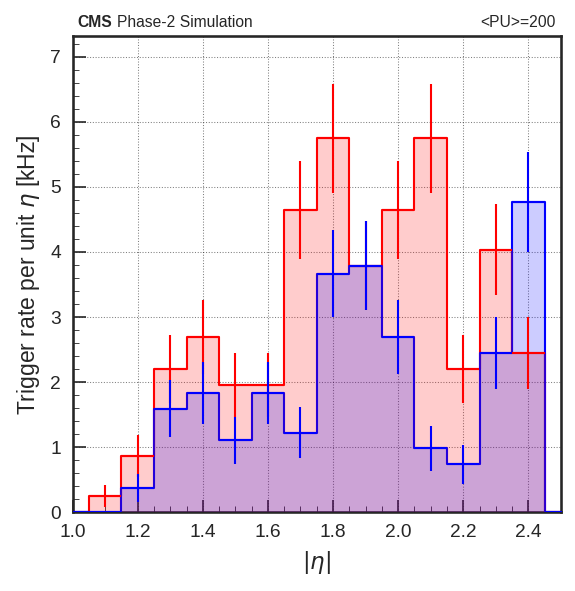

In [30]:
hname = 'emtf_ptmin20_qmin12_eta'

with root_open(infile_rates) as f:
  h_nevents = f.Get('nevents')
  assert(h_nevents != None)
  nevents = h_nevents.GetBinContent(2)

  h1a = f.Get(hname)
  h1a.SetDirectory(0) # memory resident
  make_rate(h1a, nevents)

  h1b = f.Get(hname2026_f(hname))
  h1b.SetDirectory(0) # memory resident
  make_rate(h1b, nevents)

doit()